In [1]:
import torch
from torch.utils.data import DataLoader
from torch import optim
import torchvision
#from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from copy import copy


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
device

device(type='cuda')

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = torchvision.datasets.SVHN(root='/data/torchvision', split='train' ,download=True, transform=transform)


Using downloaded and verified file: /data/torchvision/train_32x32.mat


In [5]:
dataset

Dataset SVHN
    Number of datapoints: 73257
    Root location: /data/torchvision
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
test = torchvision.datasets.SVHN(root='/data/torchvision', split='test', download=True, transform=transform)


Using downloaded and verified file: /data/torchvision/test_32x32.mat


In [7]:
test

Dataset SVHN
    Number of datapoints: 26032
    Root location: /data/torchvision
    Split: test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [8]:
#rain_size = int(len(dataset)*0.8)
#validation_size = len(dataset) - train_size

train = dataset
validation = test
#torch.utils.data.random_split(dataset, [train_size, validation_size])

In [9]:
len(train), len(validation)


(73257, 26032)

In [10]:
train_data_loader = DataLoader(train, batch_size=64)


In [11]:
images, targets = next(iter(train_data_loader))


In [12]:
images.size()


torch.Size([64, 3, 32, 32])

In [13]:
len(torch.flatten(images[0]))


3072

In [14]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [15]:
def loss_batch(model_output, loss_func, xb, yb, opt=None): #calculat loss of train
    
    output = loss_func(model_output, yb)

    if opt is not None:
        output.backward()
        opt.step()
        opt.zero_grad()

    return output.item(), len(xb)

In [16]:
def loss_batches(model, data_loader, loss_func, opt=None):
    correct = 0
    losses, batch_sizes = [], []
  
    for xb, yb in data_loader:
    
        xb, yb = xb.to(device), yb.to(device)
        model_output = model(xb)
        _, y_predict = torch.max(model_output.data, 1)
        correct += (y_predict == yb).sum().item()

        loss, batch_size = loss_batch(model_output, loss_func, xb, yb, opt)
        
        losses.append(loss)
        batch_sizes.append(batch_size)

    return correct, losses, batch_sizes

In [17]:
def calc_loss(losses, nums):
    return np.sum(np.multiply(losses, nums)) / np.sum(nums)

In [18]:
def accuracy(correct, batch_sizes):
    return correct/np.sum(batch_sizes)

In [19]:
def train_epoch(model, data_loader, loss_func, eval_func, opt):
  
    model.train()
    correct, losses, batch_sizes = loss_batches(model, data_loader, loss_func, opt)
    return eval_func(correct, batch_sizes), calc_loss(losses, batch_sizes)
     

In [20]:
def validate_epoch(model, data_loader, loss_func, eval_func, opt):
    model.eval()
    with torch.no_grad():
        correct, losses, batch_sizes = loss_batches(model, data_loader, loss_func)
        
    return eval_func(correct, batch_sizes), calc_loss(losses, batch_sizes)

In [21]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []

    for epoch in range(epochs):

        train_acc, train_loss = train_epoch(model, train_dl, loss_func, accuracy, opt)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        valid_acc, val_loss = validate_epoch(model, valid_dl, loss_func, accuracy, opt) 
        valid_accs.append(valid_acc)
        valid_losses.append(val_loss)

        print(epoch, f'train_loss={train_loss}\tval_loss={val_loss}')

    return train_losses, valid_losses, train_accs, valid_accs

In [22]:
def plot_loss(title, epochs, train_losses, val_losses):
    plt.plot(range(epochs), train_losses, label='Train')
    plt.plot(range(epochs), val_losses, label='Test')
    plt.legend()
    plt.title(title)
    plt.xlabel('epochs')

In [23]:
def get_model_cnn():
    
    in_channels = 3 #RGB

    H, D_out = 84, 10
    model = torch.nn.Sequential(
        torch.nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 2, stride = 2),
            
        torch.nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 2, stride = 2),

        torch.nn.Flatten(),
        torch.nn.Linear(400,120),
        torch.nn.ReLU(),
        torch.nn.Linear(120,84),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out),
        torch.nn.Softmax(dim=1),
    )
    model.to(device)
    
    return model, optim.Adam(model.parameters(), lr=0.001)

In [24]:
batch_size = 32
epochs = 2
loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train, validation, batch_size)
model, opt = get_model_cnn()
train_losses, val_losses, train_accs, valid_accs = fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 train_loss=2.02010223962397	val_loss=1.8966618944108302
1 train_loss=1.9011148925638415	val_loss=1.8805874251264256


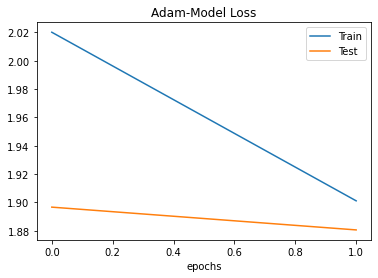

In [25]:
plot_loss('Adam-Model Loss', epochs, train_losses, val_losses)


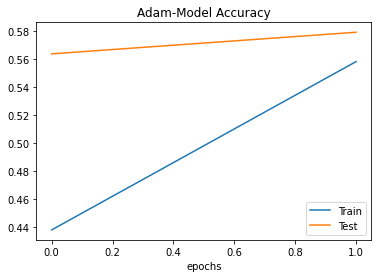

In [26]:
plot_loss('Adam-Model Accuracy', epochs, train_accs, valid_accs)


In [27]:
#loss_fn = torch.nn.CrossEntropyLoss()

test_data_loader = DataLoader(test, batch_size=64)
accuracy1, loss = validate_epoch(model, test_data_loader, loss_fn, accuracy, opt=None)

accuracy1

0.5791333743085433

In [28]:
valid_accs[-1]

0.5791333743085433

In [29]:
#torch.save(model.state_dict(), "saved__model.pt")


In [30]:
def get_model_cnn_improved():
    
    in_channels = 3 #RGB

    H, D_out = 128, 10

    model = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
        
      torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(64),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Dropout(p=0.5),
        
      torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(128),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Dropout(p=0.5),
        
      torch.nn.Flatten(),
      torch.nn.Linear(128*4*4, H),
      torch.nn.ReLU(),
      torch.nn.Linear(H, D_out),
      torch.nn.LogSoftmax(dim=1),
    )

    model.to(device)
     
    return model, optim.Adam(model.parameters(), lr=0.001)

In [31]:
batch_size = 64
epochs = 2
#loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train, validation, batch_size)
model_cnn_improved, opt = get_model_cnn_improved()

train_losses1, val_losses1, train_accs1, valid_accs1 = fit(epochs, model_cnn_improved, loss_fn, opt, train_dl, valid_dl)

0 train_loss=1.0622878871563277	val_loss=0.4989492094033176
1 train_loss=0.5549810325630578	val_loss=0.3961156567475073


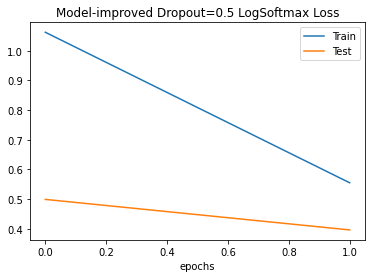

In [32]:
plot_loss('Model-improved Dropout=0.5 LogSoftmax Loss', epochs, train_losses1, val_losses1)


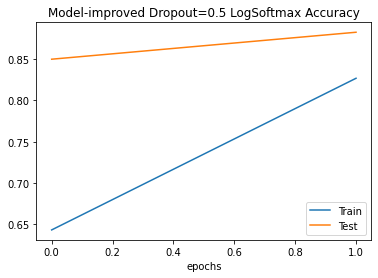

In [33]:
plot_loss('Model-improved Dropout=0.5 LogSoftmax Accuracy', epochs, train_accs1, valid_accs1)


In [34]:
valid_accs1[-1]


0.8826060233558697

In [35]:
test_data_loader = DataLoader(test, batch_size=64)
accuracy_test, loss_test = validate_epoch(model_cnn_improved, test_data_loader, loss_fn, 
                                          accuracy, opt=None)

accuracy_test

0.8826060233558697

In [40]:
batch_size = 64
epochs = 2
#loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train_transformed, validation, batch_size)
model_cnn_improved_lr1, __ = get_model_cnn_improved()
opt = optim.Adam(model_cnn_improved_lr1.parameters(), lr=0.01)

train_losses6, val_losses6, train_accs6, valid_accs6 = fit(epochs, model_cnn_improved_lr1, loss_fn, opt, train_dl, valid_dl)

0 train_loss=2.006079547446608	val_loss=1.4913854371131237
1 train_loss=0.9302556068337757	val_loss=0.6076258749923753


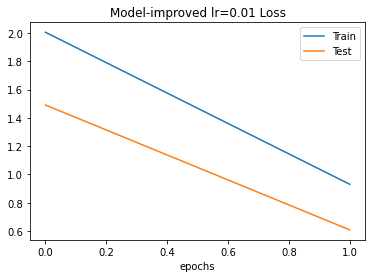

In [41]:
plot_loss('Model-improved lr=0.01 Loss', epochs, train_losses6, val_losses6)


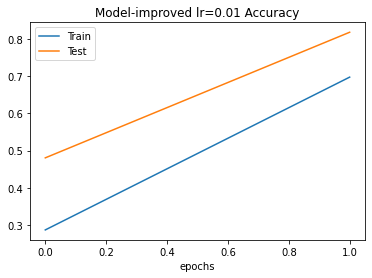

In [42]:
plot_loss('Model-improved lr=0.01 Accuracy', epochs, train_accs6, valid_accs6)


In [ ]:
batch_size = 64
epochs = 2
#loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train_transformed, validation, batch_size)
model_cnn_improved_lr2, __ = get_model_cnn_improved()
opt = optim.Adam(model_cnn_improved_lr2.parameters(), lr=0.0001)

train_losses7, val_losses7, train_accs7, valid_accs7 = fit(epochs, model_cnn_improved_lr2, loss_fn, opt, train_dl, valid_dl)

In [ ]:
plot_loss('CNN-improved lr=0.0001 Loss', epochs, train_losses7, val_losses7)


In [ ]:
plot_loss('Model-improved lr=0.0001 Accuracy', epochs, train_accs7, valid_accs7)


In [ ]:
valid_accs7[-1]


In [ ]:
test_data_loader = DataLoader(test, batch_size=64)
accuracy_test, loss_test = validate_epoch(model_cnn_improved_lr2, test_data_loader, loss_fn, 
                                          accuracy, opt=None)

accuracy_test